In [ ]:
!pip install mido
!pip install music21
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=0b50c980c8fb7d5e98b9f6c593f1b069c4923e8d68a63b7203ebcdbd26bb7e1f
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
# import sns

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read the metadata CSV file
data = spark.read.csv('gs://cs649project/CS649Data/musicnet_metadata.csv', header=True, inferSchema=True)

# Read test labels
path = 'gs://cs649project/CS649Data/musicnet-dataset/musicnet/musicnet/test_labels/*.csv'
test = spark.read.csv(path, header=True, inferSchema=True)

In [ ]:
# Add 'id' column to test dataframe
test = test.withColumn('id', col('_c0').substr(1, 6).cast('int'))

# Read train labels
path = 'gs://cs649project/CS649Data/musicnet-dataset/musicnet/musicnet/train_labels/*.csv'
train = spark.read.csv(path, header=True, inferSchema=True)

# Add 'id' column to train dataframe
train = train.withColumn('id', col('_c0').substr(1, 6).cast('int'))

# Merge data with train and test dataframes
data_train = data.join(train, on='id').drop('source', 'transcriber', 'catalog_name')
data_test = data.join(test, on='id').drop('source', 'transcriber', 'catalog_name')

# Concatenate test and train data
entire_data = data_test.union(data_train)

# Drop duplicates based on 'id'
music_info = entire_data.dropDuplicates(['id'])

# Calculate ensemble value counts
ensemble_counts = music_info.groupby('ensemble').count().alias('count')

# Convert DataFrame to Pandas for plotting
ensemble_counts_pd = ensemble_counts.toPandas()

# Plot the pie chart
labels = ensemble_counts_pd['ensemble'].tolist()
sizes = ensemble_counts_pd['count'].tolist()

<ipython-input-7-e62c17e0be77>:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


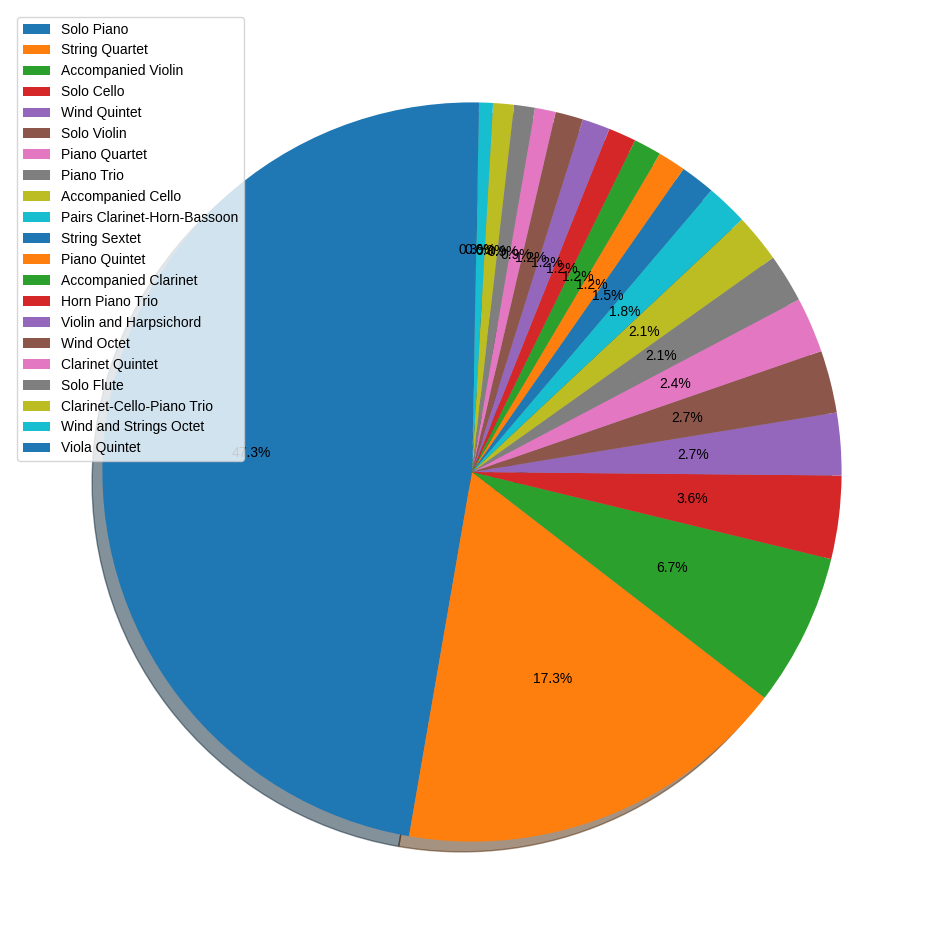

In [ ]:
plt.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%', startangle=90)
plt.gcf().set_size_inches(12, 12)
plt.legend(labels=labels, loc="best")
plt.style.use('seaborn')
plt.savefig('a.png')
plt.show()
plt.close()

<ipython-input-8-4cfdda8c13fb>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


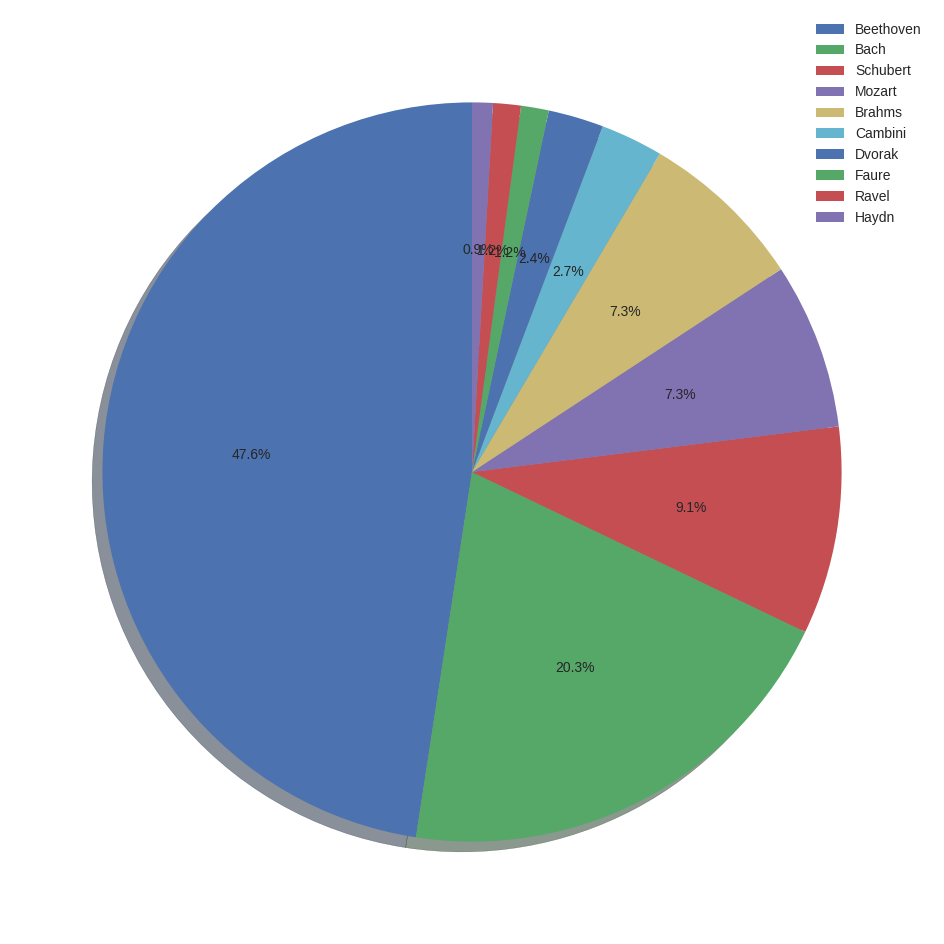

In [ ]:
composer_counts = music_info.groupBy('composer').count()

# Convert the composer counts DataFrame to Pandas for visualization
composer_counts_pandas = composer_counts.toPandas()

# Create a pie chart using the composer counts
plt.pie(composer_counts_pandas['count'], labels=composer_counts_pandas['composer'],
        shadow=True, autopct='%1.1f%%', startangle=90)
plt.gcf().set_size_inches(12, 12)
plt.legend(loc="best")
plt.style.use('seaborn')

# Display and save the chart
plt.savefig('a2.jpg')
plt.close()


<ipython-input-9-99ab71b7da7c>:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


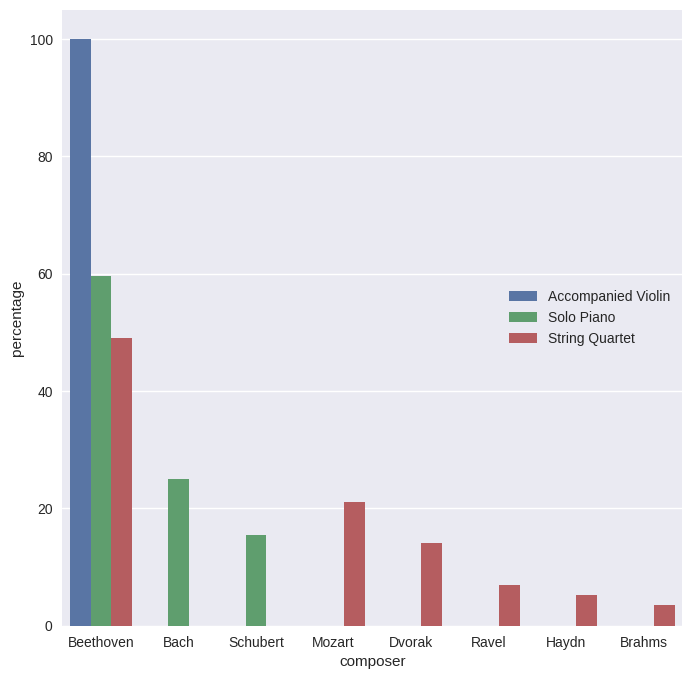

<Figure size 800x550 with 0 Axes>

In [ ]:
music_info_filtered = music_info.filter(col('ensemble').isin(['Solo Piano', 'String Quartet', 'Accompanied Violin']))

# Calculate the composer counts normalized by ensemble
ensemble_counts = music_info_filtered.groupBy('ensemble', 'composer').count()
total_counts = music_info_filtered.groupBy('ensemble').count()
ensemble_counts = ensemble_counts.join(total_counts, 'ensemble').withColumn('percentage', (col('count') / col('count_1')) * 100)

# Convert the ensemble counts DataFrame to Pandas for visualization
ensemble_counts_pandas = ensemble_counts.toPandas()

# Create a bar plot using the ensemble counts
sns.barplot(x="composer", y="percentage", hue="ensemble", data=ensemble_counts_pandas)
plt.gcf().set_size_inches(8, 8)
plt.legend(loc="right")
plt.style.use('seaborn')

# Display and save the chart
plt.savefig('a3.jpg')
plt.show()


<ipython-input-10-d6902dd625ac>:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


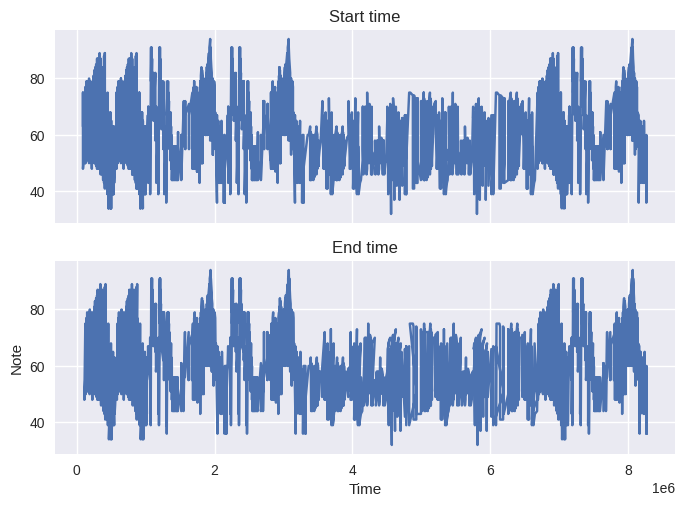

<Figure size 800x550 with 0 Axes>

In [ ]:
music_1759 = entire_data.filter(col('id') == 1759)

# Create subplots and plot the start_time and end_time against the note
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

# Collect the data from Spark DataFrame and convert to Pandas DataFrame for plotting
music_1759_pd = music_1759.select('start_time', 'note').toPandas()

ax1.plot(music_1759_pd['start_time'], music_1759_pd['note'])
ax1.set_title('Start time')

# Collect the data from Spark DataFrame and convert to Pandas DataFrame for plotting
music_1759_pd = music_1759.select('end_time', 'note').toPandas()

ax2.plot(music_1759_pd['end_time'], music_1759_pd['note'])
ax2.set_title('End time')

plt.xlabel('Time')
plt.ylabel('Note')
plt.style.use('seaborn')

# Display and save the chart
plt.savefig('a4.jpg')
plt.show()
